<a href="https://colab.research.google.com/github/blancavazquez/CursoDatosMasivosII/blob/master/notebooks/2a_apriori.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Algoritmo apriori**

En esta libreta exploraremos el modelo mercado canasta basado en el algoritmo apriori usando una base de datos de transacciones de una tienda de productos comestibles.


In [1]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle.json': b'{"username":"blancavazquez","key":"2300dcedb90eb3926c4113d0c1165129"}'}

In [2]:
 #conexión kaggle + colab
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d roshansharma/market-basket-optimization
!unzip market-basket-optimization.zip

  0% 0.00/46.9k [00:00<?, ?B/s]
100% 46.9k/46.9k [00:00<00:00, 40.2MB/s]
Archive:  market-basket-optimization.zip
  inflating: Market_Basket_Optimisation.csv  


In [3]:
#!pip install squarify

## Carga y exploración de la base de datos



In [4]:
# Carga de bibliotecas
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
#import squarify
import seaborn as sns
plt.style.use('fivethirtyeight')

import os

# for market basket analysis
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [5]:
#Carga de los datos
data = pd.read_csv('/content/Market_Basket_Optimisation.csv', header = None)
print(data.shape) #visualizamos el tamaño de la bd

(7501, 20)


In [6]:
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,shrimp,almonds,avocado,vegetables mix,green grapes,whole weat flour,yams,cottage cheese,energy drink,tomato juice,low fat yogurt,green tea,honey,salad,mineral water,salmon,antioxydant juice,frozen smoothie,spinach,olive oil
1,burgers,meatballs,eggs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chutney,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,turkey,avocado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,mineral water,milk,energy bar,whole wheat rice,green tea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
data.sample(10) #revisamos algunas entradas aleatorias

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
3699,green tea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5188,spaghetti,gluten free bar,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3049,ground beef,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4255,frozen vegetables,whole wheat rice,energy drink,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2110,turkey,ground beef,pepper,flax seed,bacon,salmon,pet food,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3528,turkey,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
264,muffins,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5526,whole wheat pasta,spaghetti,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
155,shrimp,pasta,spaghetti,eggs,hot dogs,green tea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
997,frozen smoothie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


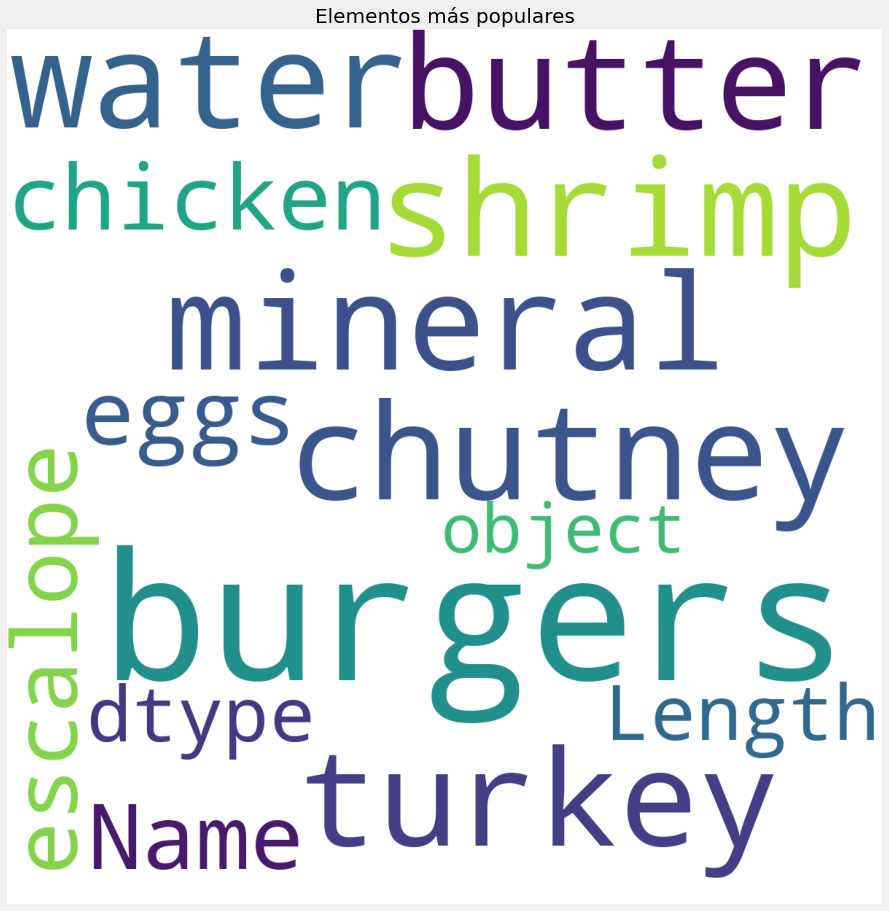

In [8]:
#Generamos algunas visualizaciones
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

plt.rcParams['figure.figsize'] = (15, 15)
wordcloud = WordCloud(background_color = 'white', width = 1200,  height = 1200, max_words = 121).generate(str(data[0]))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Elementos más populares',fontsize = 20)
plt.show()

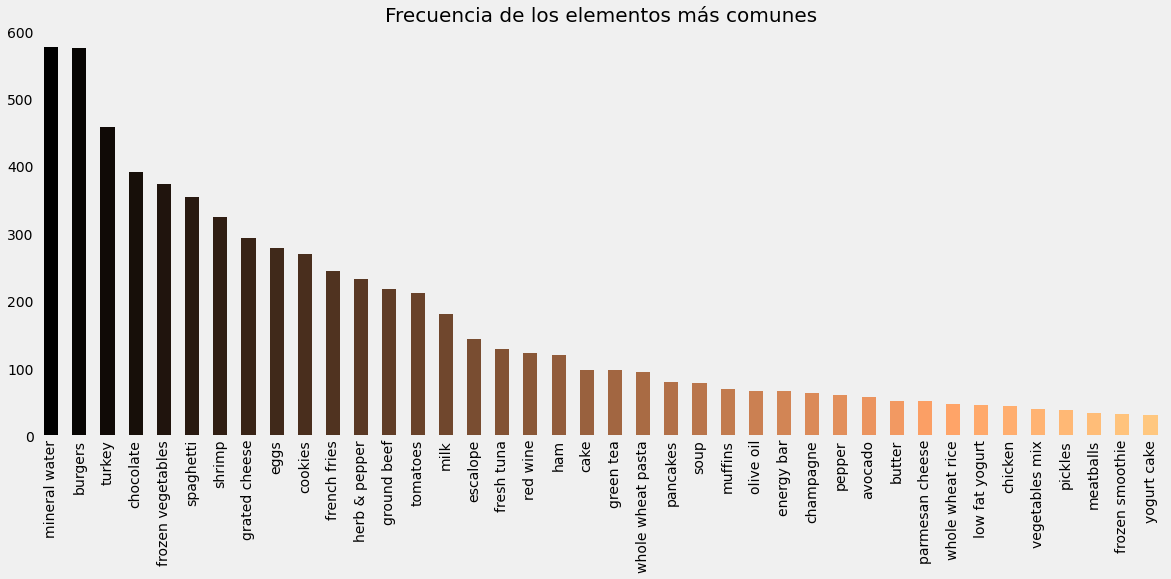

In [9]:
plt.rcParams['figure.figsize'] = (18, 7)
color = plt.cm.copper(np.linspace(0, 1, 40))
data[0].value_counts().head(40).plot.bar(color = color)
plt.title('Frecuencia de los elementos más comunes', fontsize = 20)
plt.xticks(rotation = 90 )
plt.grid()
plt.show()

## Pre-procesamiento de la base de datos

In [10]:
# generamos una lista de compras
trans = []
for i in range(0, 7501):
    trans.append([str(data.values[i,j]) for j in range(0, 20)])

# se convierte la lista a un array de numpy.
trans = np.array(trans)
print(trans.shape)

(7501, 20)


In [11]:
print(trans) #visualizamos la lista

[['shrimp' 'almonds' 'avocado' ... 'frozen smoothie' 'spinach'
  'olive oil']
 ['burgers' 'meatballs' 'eggs' ... 'nan' 'nan' 'nan']
 ['chutney' 'nan' 'nan' ... 'nan' 'nan' 'nan']
 ...
 ['chicken' 'nan' 'nan' ... 'nan' 'nan' 'nan']
 ['escalope' 'green tea' 'nan' ... 'nan' 'nan' 'nan']
 ['eggs' 'frozen smoothie' 'yogurt cake' ... 'nan' 'nan' 'nan']]


In [12]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
data = te.fit_transform(trans) #aprende las etiquetas únicas de la bd y las transforma en one-hot encoding
data = pd.DataFrame(data, columns = te.columns_)

data.shape #visualizamos el tamaño de los datos

(7501, 121)

In [13]:
data

,asparagus,almonds,antioxydant juice,asparagus,avocado,babies food,bacon,barbecue sauce,black tea,blueberries,body spray,bramble,brownies,bug spray,burger sauce,burgers,butter,cake,candy bars,carrots,cauliflower,cereals,champagne,chicken,chili,chocolate,chocolate bread,chutney,cider,clothes accessories,cookies,cooking oil,corn,cottage cheese,cream,dessert wine,eggplant,eggs,energy bar,energy drink,...,oil,olive oil,pancakes,parmesan cheese,pasta,pepper,pet food,pickles,protein bar,red wine,rice,salad,salmon,salt,sandwich,shallot,shampoo,shrimp,soda,soup,spaghetti,sparkling water,spinach,strawberries,strong cheese,tea,tomato juice,tomato sauce,tomatoes,toothpaste,turkey,vegetables mix,water spray,white wine,whole weat flour,whole wheat pasta,whole wheat rice,yams,yogurt cake,zucchini
0,False,True,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,...,False,True,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,True,False,False,True,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7496,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False

In [14]:
import warnings
warnings.filterwarnings('ignore')

#de total de elementos, seleccionamos un conjunto (los más frecuentes)

data = data.loc[:, ['mineral water', 'burgers', 'turkey', 'chocolate', 'frozen vegetables', 'spaghetti',
                    'shrimp', 'grated cheese', 'eggs', 'cookies', 'french fries', 'herb & pepper', 'ground beef',
                    'tomatoes', 'milk', 'escalope', 'fresh tuna', 'red wine', 'ham', 'cake', 'green tea',
                    'whole wheat pasta', 'pancakes', 'soup', 'muffins', 'energy bar', 'olive oil', 'champagne', 
                    'avocado', 'pepper', 'butter', 'parmesan cheese', 'whole wheat rice', 'low fat yogurt', 
                    'chicken', 'vegetables mix', 'pickles', 'meatballs', 'frozen smoothie', 'yogurt cake']]

# checking the shape
data.shape

(7501, 40)

In [15]:
data.columns #revisamos las columnas

Index(['mineral water', 'burgers', 'turkey', 'chocolate', 'frozen vegetables',
       'spaghetti', 'shrimp', 'grated cheese', 'eggs', 'cookies',
       'french fries', 'herb & pepper', 'ground beef', 'tomatoes', 'milk',
       'escalope', 'fresh tuna', 'red wine', 'ham', 'cake', 'green tea',
       'whole wheat pasta', 'pancakes', 'soup', 'muffins', 'energy bar',
       'olive oil', 'champagne', 'avocado', 'pepper', 'butter',
       'parmesan cheese', 'whole wheat rice', 'low fat yogurt', 'chicken',
       'vegetables mix', 'pickles', 'meatballs', 'frozen smoothie',
       'yogurt cake'],
      dtype='object')

In [16]:
data.head()

,mineral water,burgers,turkey,chocolate,frozen vegetables,spaghetti,shrimp,grated cheese,eggs,cookies,french fries,herb & pepper,ground beef,tomatoes,milk,escalope,fresh tuna,red wine,ham,cake,green tea,whole wheat pasta,pancakes,soup,muffins,energy bar,olive oil,champagne,avocado,pepper,butter,parmesan cheese,whole wheat rice,low fat yogurt,chicken,vegetables mix,pickles,meatballs,frozen smoothie,yogurt cake
0,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,True,False,False,False,False,True,False,True,False,False,True,False
1,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
4,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False


## Algoritmo Apriori


In [24]:
from mlxtend.frequent_patterns import apriori #http://rasbt.github.io/mlxtend/

#seleccionamos los elementos con un soporte mínimo (minsup) = 0.03
apriori(data, min_support = 0.03, use_colnames = True) #http://rasbt.github.io/mlxtend/api_subpackages/mlxtend.frequent_patterns/

,support,itemsets
0,0.238368,(mineral water)
1,0.087188,(burgers)
2,0.062525,(turkey)
3,0.163845,(chocolate)
4,0.095321,(frozen vegetables)
5,0.174110,(spaghetti)
6,0.071457,(shrimp)
7,0.052393,(grated cheese)
8,0.179709,(eggs)
9,0.080389,(cookies)


Asumimos que:


*   Estamos interesados en elementos de tamaño 2
*   El soporte mínimo minsup = 0.03



## Seleccionamos y filtramos los resultados

In [25]:
frequent_itemsets = apriori(data, min_support = 0.03, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets

,support,itemsets,length
0,0.238368,(mineral water),1
1,0.087188,(burgers),1
2,0.062525,(turkey),1
3,0.163845,(chocolate),1
4,0.095321,(frozen vegetables),1
5,0.174110,(spaghetti),1
6,0.071457,(shrimp),1
7,0.052393,(grated cheese),1
8,0.179709,(eggs),1
9,0.080389,(cookies),1


In [28]:
frequent_itemsets[ (frequent_itemsets['length'] == 2) &
                   (frequent_itemsets['support'] >= 0.05) ]

,support,itemsets,length
28,0.052660,"(chocolate, mineral water)",2
30,0.059725,"(spaghetti, mineral water)",2
31,0.050927,"(mineral water, eggs)",2


In [29]:
#Revisamos el soporte de elementos definidos
frequent_itemsets[ frequent_itemsets['itemsets'] == {'eggs', 'mineral water'} ]

,support,itemsets,length
31,0.050927,"(mineral water, eggs)",2


In [30]:
frequent_itemsets[ frequent_itemsets['itemsets'] == {'mineral water'} ]

,support,itemsets,length
0,0.238368,(mineral water),1


### Usando los mismos datos, ejecutamos el algoritmo apriori usando la biblioteca "apyori"

In [31]:
!pip install apyori

  Created wheel for apyori: filename=apyori-1.1.2-cp36-none-any.whl size=5975 sha256=680c590957f0c3c8c83dc9dad749d6dcbb1c0a5a2870d1abcef433b81f238f8f
  Stored in directory: /root/.cache/pip/wheels/5d/92/bb/474bbadbc8c0062b9eb168f69982a0443263f8ab1711a8cad0
Successfully built apyori


In [32]:
# Training Apriori on the dataset
from apyori import apriori #https://pypi.org/project/apyori/
rules = apriori(trans, min_support = 0.003, min_confidence = 0.2, min_lift = 3, min_length = 2)

In [33]:
# Resultados
results = list(rules)

In [34]:
def inspect(results):
    rh          = [tuple(result[2][0][0]) for result in results]
    lh          = [tuple(result[2][0][1]) for result in results]
    supports    = [result[1] for result in results]
    confidences = [result[2][0][2] for result in results]
    lifts       = [result[2][0][3] for result in results]
    return list(zip(rh, lh, supports, confidences, lifts))

In [35]:
# Este comando crea un dataframe para ver los resultados
resultDataFrame=pd.DataFrame(inspect(results),
                columns=['X','Y','soporte','confianza','sustento'])

In [42]:
#Imprimimos el frame con las reglas
resultDataFrame.sample(5)

,X,Y,soporte,confianza,sustento
104,"(spaghetti, mineral water, frozen vegetables)","(tomatoes,)",0.003066,0.255556,3.736690
76,"(chocolate, ground beef, frozen vegetables)","(spaghetti,)",0.003066,0.534884,3.072100
148,"(ground beef, frozen vegetables)","(spaghetti, mineral water, nan)",0.004399,0.259843,4.350622
72,"(chicken, milk)","(olive oil, nan)",0.003600,0.243243,3.700948
79,"(chocolate, mineral water, frozen vegetables)","(shrimp,)",0.003200,0.328767,4.600900
